In [1]:
# gpu
! nvidia-smi

Sun May  1 21:22:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.69       Driver Version: 511.69       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8     5W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.11.0


## Data transform

In [7]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [8]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
train_dirs = {
    'normal': 'D:\\abhijeet\\desktop\\Data\\Normal\\Train',
    'viral': 'D:\\abhijeet\\desktop\\Data\\Viral Pneumonia\\Train',
    'covid': 'D:\\abhijeet\\desktop\\Data\\COVID\\Train'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1000 normal examples
Found 1000 viral examples
Found 1000 covid examples


In [12]:
test_dirs = {
    'normal': 'D:\\abhijeet\\desktop\\Data\\Normal\\Test',
    'viral': 'D:\\abhijeet\\desktop\\Data\\Viral Pneumonia\\Test',
    'covid': 'D:\\abhijeet\\desktop\\Data\\COVID\\Test'
}


test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 100 normal examples
Found 100 viral examples
Found 100 covid examples


In [13]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 500
Number of test batches 50


## Visualise data

In [14]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

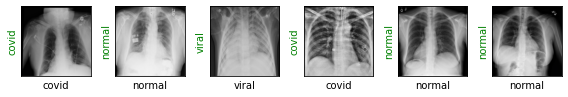

In [15]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

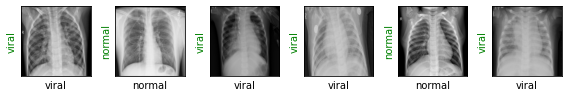

In [16]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

## Creating the Model

In [17]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\abhijeet/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [19]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

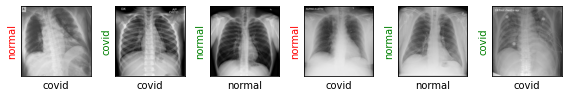

In [20]:
show_preds()

## Training the Model

In [21]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.0914, Accuracy: 0.3733


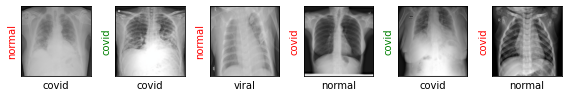

Evaluating at step 20
Validation Loss: 0.9037, Accuracy: 0.5433


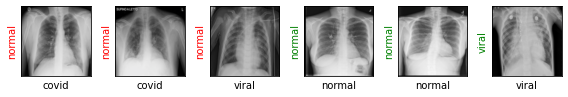

Evaluating at step 40
Validation Loss: 0.7128, Accuracy: 0.7267


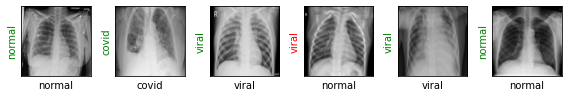

Evaluating at step 60
Validation Loss: 0.8010, Accuracy: 0.7400


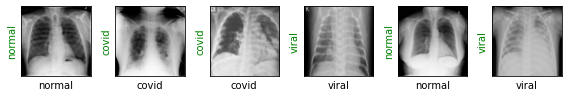

Evaluating at step 80
Validation Loss: 0.6722, Accuracy: 0.8000


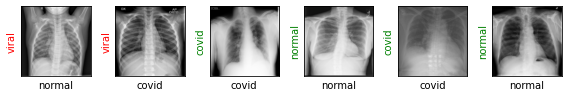

Evaluating at step 100
Validation Loss: 0.7207, Accuracy: 0.8033


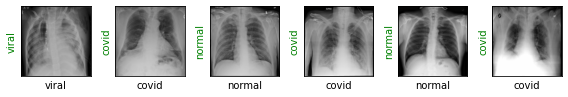

Evaluating at step 120
Validation Loss: 0.6550, Accuracy: 0.8233


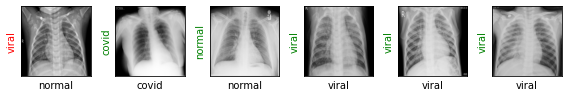

Evaluating at step 140
Validation Loss: 0.7541, Accuracy: 0.8067


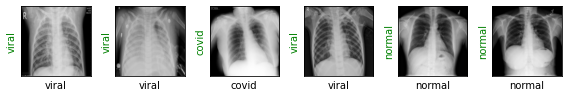

Evaluating at step 160
Validation Loss: 0.7093, Accuracy: 0.8200


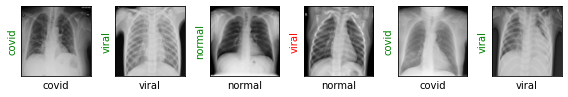

Evaluating at step 180
Validation Loss: 0.6434, Accuracy: 0.8300


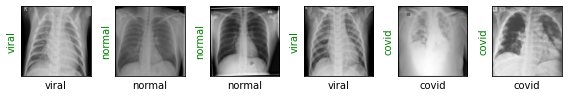

Evaluating at step 200
Validation Loss: 0.7178, Accuracy: 0.8267


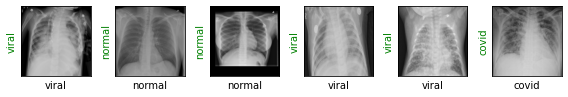

Evaluating at step 220
Validation Loss: 0.7245, Accuracy: 0.8300


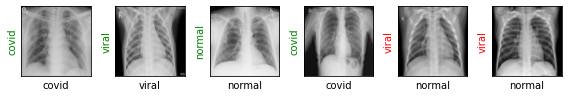

Evaluating at step 240
Validation Loss: 0.6608, Accuracy: 0.8433


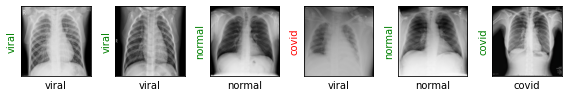

Evaluating at step 260
Validation Loss: 0.9444, Accuracy: 0.8000


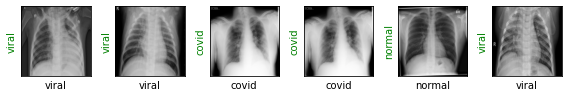

Evaluating at step 280
Validation Loss: 0.9529, Accuracy: 0.8100


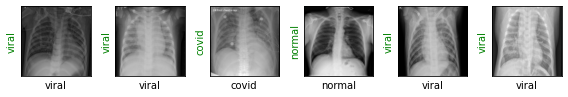

Evaluating at step 300
Validation Loss: 0.9204, Accuracy: 0.8067


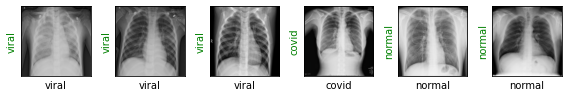

Evaluating at step 320
Validation Loss: 0.9410, Accuracy: 0.8000


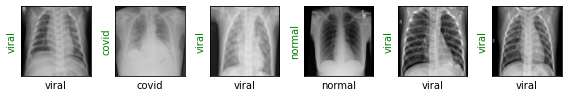

Evaluating at step 340
Validation Loss: 0.8610, Accuracy: 0.8333


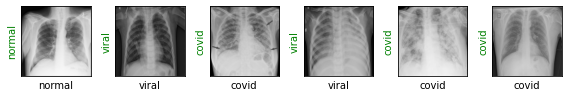

Evaluating at step 360
Validation Loss: 0.7689, Accuracy: 0.8633


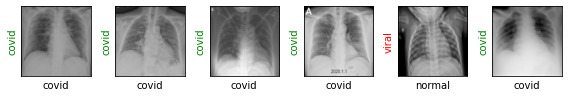

Evaluating at step 380
Validation Loss: 0.9637, Accuracy: 0.8333


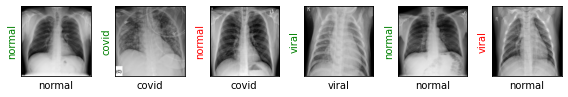

Evaluating at step 400
Validation Loss: 0.9090, Accuracy: 0.8100


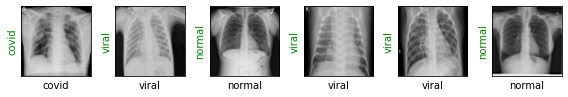

Evaluating at step 420
Validation Loss: 0.7758, Accuracy: 0.8533


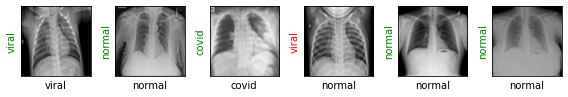

Evaluating at step 440
Validation Loss: 0.7020, Accuracy: 0.8600


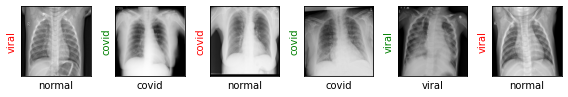

Evaluating at step 460
Validation Loss: 0.7717, Accuracy: 0.8267


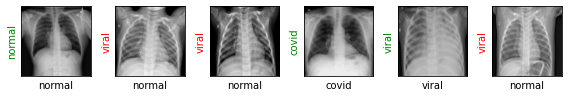

Evaluating at step 480
Validation Loss: 0.8503, Accuracy: 0.8100


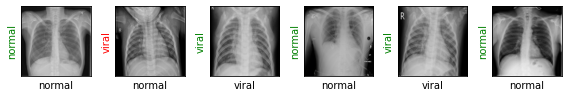

Training Loss: 0.2846
Training complete..
Wall time: 10min 8s


In [22]:
%%time

train(epochs=1)

## Show the Predictions

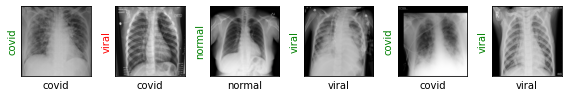

In [99]:
show_preds()

## *Saving* the Model

In [28]:
torch.save(resnet18.state_dict(), 'D:\\abhijeet\\desktop\\Data\\covid_classifier.pt')

##  Inference on a Single Image

In [102]:
# Load the model and set in eval
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.load_state_dict(torch.load('D:\\abhijeet\\desktop\\Data\\covid_classifier.pt'))
resnet18.eval()


def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    # Please note that the transform is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    return probabilities, predicted_class_index, predicted_class_name

In [103]:
image_path = 'D:\\abhijeet\\desktop\\Data\\COVID\\Test\\COVID-3.png'

probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [0.36084816 0.00220863 0.63694316]
Predicted class index: 2
Predicted class name: covid


In [120]:
ypred=[[0,0,0]]
import os
for image in os.listdir(test_dirs['normal']):
    image = os.path.join(test_dirs['normal'], image)
    probabilities, predicted_class_index, predicted_class_name = predict_image_class(image)
    ypred.append(probabilities)
ypred = ypred[1:]
for image in os.listdir(test_dirs['viral']):
    image = os.path.join(test_dirs['viral'], image)
    probabilities, predicted_class_index, predicted_class_name = predict_image_class(image)
    ypred.append(probabilities)
for image in os.listdir(test_dirs['covid']):
    image = os.path.join(test_dirs['covid'], image)
    probabilities, predicted_class_index, predicted_class_name = predict_image_class(image)
    ypred.append(probabilities)


In [121]:
y=[0 for x in range (0,100)]
y=y+[1 for x in range(0,100)]
y=y+[2 for x in range(0,100)]
y=np.array(y)
ypred = np.array(ypred)

In [122]:
ypred=np.argmax(ypred, axis=1)

In [125]:
matrix = confusion_matrix(y,ypred)

In [126]:
print(matrix)

[[ 61  38   1]
 [  0 100   0]
 [  9   3  88]]


<AxesSubplot:>

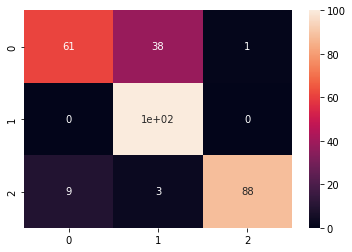

In [127]:
import seaborn as sns
sns.heatmap(matrix, annot=True)